In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim


class LAM_Linear(nn.Module):
    def __init__(self, d_o, d_z):
        super(LAM_Linear, self).__init__()
        # self.A = nn.Linear(d_o, d_o, bias=False)
        # self.B = nn.Linear(d_z, d_o, bias=False)
        self.C = nn.Linear(d_o, d_z, bias=False)
        self.D = nn.Linear(d_o, d_z, bias=False)
        self.E = nn.Linear(d_z, d_o, bias=False)


    def forward(self, o, o_next):
        z = self.C(o) + self.D(o_next)
        obs_pred = o + self.E(z)
        return obs_pred

In [2]:
def generate_true_U(action_embeddings):
    N = 10000

    actions = np.random.randint(num_actions, size=(N,))
    A = np.zeros((num_actions, N))
    A[actions, np.arange(N)] = 1

    Q = action_embeddings @ A 

    U, S, V = np.linalg.svd(Q)
    return U

def principal_angles(X, Y):
    # Orthonormalize the basis vectors using QR decomposition
    Q1, _ = np.linalg.qr(X)
    Q2, _ = np.linalg.qr(Y)
    
    # Compute the product of transposed Q1 and Q2
    M = Q1.T @ Q2
    
    # Singular Value Decomposition (SVD)
    U, S, Vt = np.linalg.svd(M)

    # Clip singular values to avoid numerical errors (arccos domain [-1, 1])
    S_clipped = np.clip(S, -1.0, 1.0)

    # Compute principal angles in radians (sorted in ascending order)
    angles_rad = np.arccos(S_clipped)
    
    return angles_rad

def tensorboard_smooth(data, alpha=0.6):
    """Apply exponential moving average smoothing to 1D data.
    
    Args:
        data: Input array (np.ndarray or pd.Series)
        alpha: Smoothing factor (0 < alpha ≤ 1), default 0.6 (TensorBoard's default)
    
    Returns:
        Smoothed array with same dtype as input
    """
    # Convert Series to numpy array while preserving index
    if isinstance(data, pd.Series):
        original_index = data.index
        data = data.values
    else:
        original_index = None

    smoothed = np.zeros_like(data)
    smoothed[0] = data[0]
    
    for i in range(1, len(data)):
        smoothed[i] = alpha * data[i] + (1 - alpha) * smoothed[i-1]

    # Reconstruct original data type
    return pd.Series(smoothed, index=original_index) if original_index is not None else smoothed

In [5]:
record = []

for da in [1, 2, 4, 6, 8, 10, 12, 14, 16]:
    for dz in range(1, 16):

        N = 128
        num_actions = da
        dim = 128
        dim_z = dz
        discrete_actions = True

        action_embeddings = np.random.randn(dim, num_actions)
        action_embeddings, _ = np.linalg.qr(action_embeddings) 
        action_embeddings = action_embeddings
        # action_embeddings = action_embeddings / np.linalg.norm(action_embeddings, axis=0, keepdims=True)

        lam = LAM_Linear(dim, dim_z)
        opt = optim.Adam(lam.parameters())

        for i_batch in range(5000):

            if discrete_actions:
                actions = np.random.randint(num_actions, size=(N,))
                A = np.zeros((num_actions, N))
                A[actions, np.arange(N)] = 1
            else:
                A = np.random.rand(num_actions, N)

            Q = action_embeddings @ A 

            O = np.random.rand(dim, N)
            Op = O + Q 

            tensor_O = torch.tensor(O.T, dtype=torch.float32)
            tensor_Op = torch.tensor(Op.T, dtype=torch.float32)

            loss = nn.MSELoss()(lam(tensor_O, tensor_Op), tensor_Op)
            opt.zero_grad()
            loss.backward()
            opt.step()

            angles = principal_angles(action_embeddings, lam.E.weight.detach().numpy())
            max_angle = np.max(angles)

            record.append({
                'batch': i_batch,
                'loss': loss.item(),
                'angle': max_angle,
                'da': da,
                'dz': dz,
            })

record = pd.DataFrame(record)


In [9]:
mean_loss = (
    record[(record['batch'] >= 4500) & (record['batch'] <= 5000)]
    .groupby(['da', 'dz'])['loss']
    .mean()
    .reset_index()
)

Text(0, 0.5, 'Final Reconstruction Loss')

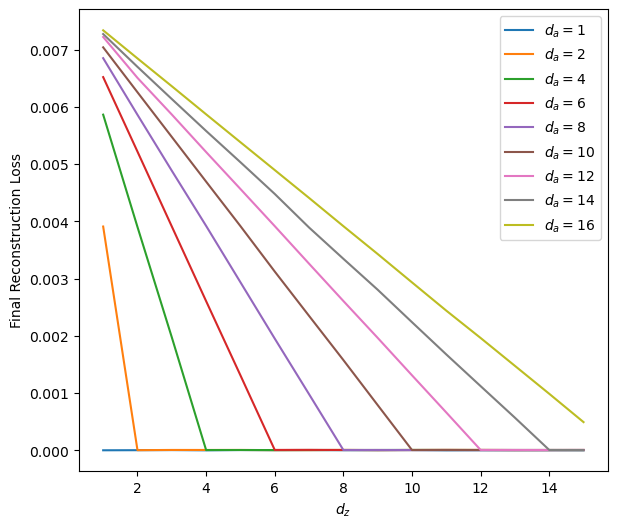

In [15]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
for da in [1, 2, 4, 6, 8, 10, 12, 14, 16]:
    losses = [mean_loss[(mean_loss['da'] == da) & (mean_loss['dz'] == dz)]['loss'].item() for dz in range(1, 16)]
    plt.plot(np.arange(1, 16), np.array(losses), label=f'$d_a ={da}$')
plt.legend()
# plt.ylim([2e-3, 20])
# plt.xlim([0, 5000])
# plt.yscale('log')
plt.xlabel('$d_z$')
plt.ylabel('Final Reconstruction Loss')